In [1]:
from data_tools.api import *
from utilscht.Data import *
import pymysql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from joblib import Parallel,delayed
import datetime
import math
%config InlineBackend.figure_format ='retina'
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

DB_INFO = dict(host='192.168.1.234',
               user='winduser',
               password='1qaz@WSX',
               db='wind')

conn = pymysql.connect(**DB_INFO, charset='utf8mb4', cursorclass=pymysql.cursors.DictCursor)

In [66]:
!tar -zxvf data/future_data.tar.gz

future_data/./
future_data/./min_hq_JM.csv
future_data/./daily_hq_JM.csv
future_data/./dominant_contract_JM.csv
future_data/./min_hq_RB.csv
future_data/./min_hq_J.csv
future_data/./min_hq_MA.csv
future_data/./daily_hq_MA.csv
future_data/./daily_hq_PP.csv
future_data/./dominant_contract_PP.csv
future_data/./min_hq_A.csv
future_data/./daily_hq_M.csv
future_data/./dominant_contract_C.csv
future_data/./daily_hq_I.csv
future_data/./dominant_contract_I.csv
future_data/./dominant_contract_J.csv
future_data/./daily_hq_Y.csv
future_data/./min_hq_M.csv
future_data/./dominant_contract_M.csv
future_data/./daily_hq_JD.csv
future_data/./daily_hq_RB.csv
future_data/./min_hq_PP.csv
future_data/./dominant_contract_A.csv
future_data/./dominant_contract_RB.csv
future_data/./daily_hq_J.csv
future_data/./min_hq_C.csv
future_data/./daily_hq_C.csv
future_data/./min_hq_I.csv
future_data/./dominant_contract_MA.csv
future_data/./min_hq_Y.csv
future_data/./dominant_contract_Y.csv
future_data/./daily_hq_A.csv
fut

In [ ]:
np?

In [2]:
def apply_parallel(df_grouped, func, n_jobs=16, backend='loky', as_index=True, **kwargs):
    """
    This is for parallel between grouped generated by pd.DataFrame.groupby
    :param df_grouped:
    :param func:
    :param n_jobs:
    :param backend:
    :param kwargs:
    :return:
    """

    names = []
    groups = []
    for name, group in df_grouped:
        names.append(name)
        groups.append(group)

    results = Parallel(n_jobs=n_jobs, verbose=5, backend=backend, batch_size='auto') \
        (delayed(func)(group, **kwargs) for group in groups)

    return pd.concat(results, keys=names if as_index else None)

In [3]:
from numpy.lib.stride_tricks import as_strided as stride
import pandas as pd

def rolling(df, w, **kwargs):
    v = df.values
    d0, d1 = v.shape
    s0, s1 = v.strides
    
    a = stride(v, (d0 - (w - 1), w, d1), (s0, s0, s1))

    rolled_df = pd.concat({
        row: pd.DataFrame(values, columns=df.columns)
        for row, values in zip(df.index, a)
    })

    return rolled_df.groupby(level=0, **kwargs)

In [4]:
from data_tools.api import trade_days

trade_dates_all = trade_days.copy()
def get_prev_n_trade_date(trade_date, n):
    trade_date=str(trade_date)[0:10].replace('-','')
    pos = np.searchsorted(trade_dates_all, trade_date)
    try:
        assert pos >= n
        return str(trade_dates_all[pos - n])
    except AssertionError:
        return "20200101"

def get_next_n_trade_date(trade_date, n=1):
    trade_date=str(trade_date)[0:10].replace('-','')
    pos = np.searchsorted(trade_dates_all, trade_date, side='right')
    try:
        assert pos + n - 1 < len(trade_dates_all)
        return str(trade_dates_all[pos + n - 1])
    except AssertionError:
        return "20201231"

In [5]:
df_IC = pd.read_csv(r"data/IC_near&far_month.csv")
df_IC = df_IC.set_index("datetime")
df_IC.index = pd.to_datetime(df_IC.index)

## 截取2019年之后的数据

In [6]:
df_IC = df_IC.loc["20190101":]

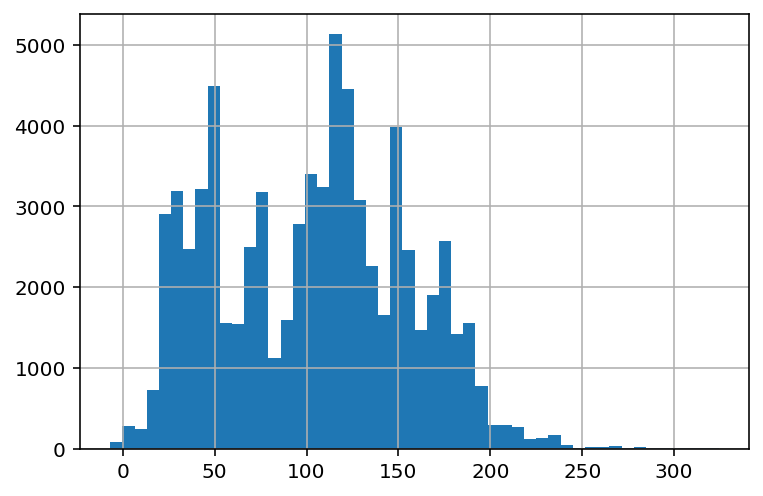

In [7]:
df_close_compare = pd.pivot_table(df_IC,"close",index= "datetime", columns = "type")
df_close_compare["spread"] = df_close_compare["NearMonth"]- df_close_compare["FarMonth"]
df_close_compare["spread"].hist(bins = 50)
df_close_compare["datetime"] = df_close_compare.index
df_close_compare["index_2"] = np.arange(len(df_close_compare))
df_close_compare["date"] = df_close_compare["datetime"].apply(lambda x:str(x)[0:10].replace('-',''))

In [ ]:
ts_standardize = lambda x:(x[-1]-np.nanmean(x))/np.nanstd(x,ddof=1) if len(x)>1 else np.nan
df_close_compare["spread_std"] = df_close_compare["spread"].rolling(2400).apply(ts_standardize)
df_close_compare["spread_std_clipped"]= np.clip(df_close_compare["spread_std"],-5,5)
df_close_compare["spread_std_clipped"].hist(bins =50)

In [ ]:
plt.plot(df_close_compare["index_2"].loc["20190425":"20190507"].iloc[::5],
         df_close_compare["spread_std"].loc["20190425":"20190507"].iloc[::5])
plt.show()
plt.plot(df_close_compare["index_2"].loc["20190425":"20190507"].iloc[::5],
         df_close_compare["spread"].loc["20190425":"20190507"].iloc[::5])
plt.show()

In [8]:
from statsmodels.tsa.stattools import coint

def co_intergrate(df,regress_period=10):    
    date_td = str(df.index[-1][0])[0:10]
    
    close_far_month=df["FarMonth"] #/ df["FarMonth"].iloc[0]
    close_near_month = df["NearMonth"] #/df["NearMonth"].iloc[0]
    
    coint_test = coint(close_far_month,close_near_month)
    
    model = sm.OLS(close_far_month,sm.add_constant(close_near_month))
    result = model.fit()
    resid_seq = result.resid
    params = result.params
    rsquare = result.rsquared

    return pd.DataFrame(data = [[params[0],params[1],np.std(resid_seq),rsquare,coint_test[1]]],
                        columns = ["beta0","beta1","resid_std","rsquare","p_value"]
                        ,index = [get_next_trade_date(date_td.replace("-",""))])

In [9]:
df_close_compare["date"] = df_close_compare["datetime"].apply(lambda x:str(x)[0:10].replace("-",""))
df_close_compare_simplified = df_close_compare.iloc[5::6][["FarMonth","NearMonth"]]
df_close_compare_simplified["spread"] = df_close_compare_simplified["NearMonth"]-df_close_compare_simplified["FarMonth"]


grouped = rolling(df_close_compare_simplified,w=480)

names = []
groups = []
for name , group in grouped:
    #if str(name)[11:19] == "14:56:00":
    names.append(name)
    groups.append(group)

In [10]:
results = Parallel(n_jobs=16, verbose=5, backend='loky', batch_size='auto') \
        (delayed(co_intergrate)(group) for group in groups)

df_result = pd.concat(results,keys = names)
df_result=df_result.reset_index().rename(columns={"level_0":"datetime","level_1":"date"})
#df_close_compare = pd.merge(df_close_compare,df_result,on = "date")

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:    2.0s
[Parallel(n_jobs=16)]: Done 130 tasks      | elapsed:    2.7s
[Parallel(n_jobs=16)]: Done 256 tasks      | elapsed:    3.7s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    5.1s
[Parallel(n_jobs=16)]: Done 640 tasks      | elapsed:    6.8s
[Parallel(n_jobs=16)]: Done 1108 tasks      | elapsed:    9.3s
[Parallel(n_jobs=16)]: Done 1648 tasks      | elapsed:   12.2s
[Parallel(n_jobs=16)]: Done 2260 tasks      | elapsed:   15.4s
[Parallel(n_jobs=16)]: Done 2944 tasks      | elapsed:   19.0s
[Parallel(n_jobs=16)]: Done 3700 tasks      | elapsed:   23.2s
[Parallel(n_jobs=16)]: Done 4528 tasks      | elapsed:   27.6s
[Parallel(n_jobs=16)]: Done 5428 tasks      | elapsed:   32.4s
[Parallel(n_jobs=16)]: Done 6400 tasks      | elapsed:   37.7s
[Parallel(n_jobs=16)]: Done 7444 tasks      | elapsed:   43.3s
[Parallel(n_jobs=16)]: Done 8560 tasks      | 

In [11]:
def get_weekday(date):
    dt = datetime.date(int(date[0:4]),int(date[4:6]),int(date[6:8]))
    return (int(date[6:8])//7+1 , dt.weekday()+1)
df_result["weekday"] = df_result["date"].apply(lambda x:get_weekday(x))

In [12]:
df_close_compare = pd.merge(df_close_compare,df_result,on = "date")

In [13]:
df_close_compare["resid"] = (df_close_compare["FarMonth"] - df_close_compare["NearMonth"]*df_close_compare["beta1"]-\
                                 df_close_compare["beta0"])/df_close_compare["resid_std"]

In [ ]:
df_close_compare[df_close_compare["date"]=="20200304"]["spread"].plot()
plt.show()
df_close_compare[df_close_compare["date"]=="20200304"]["resid"].plot()
plt.show()

In [ ]:
df_close_compare.set_index("datetime").loc["20170101":].iloc[::60]["spread"].plot()

In [ ]:
from bokeh.io import output_notebook
output_notebook()

In [ ]:
from bokeh.plotting import figure, output_file, show
output_file("lines.html")
# create a new plot with a title and axis labels
p = figure(title="simple line example", x_axis_label='x', y_axis_label='y')
# add a line renderer with legend and line thickness
p.line(df_close_compare["spread"].iloc[::6].index,
       df_close_compare["spread"].iloc[::6], 
       legend_label="Temp.", line_width=2)
# show the results
df_daily = df_close_compare.iloc[::240]
p.scatter(df_daily.index,df_daily.spread,color = "red")
df_monthly = df_daily[df_daily["weekday"] == (3,5)]
p.scatter(df_monthly.index,df_monthly.spread,color = "green",size = 10)
show(p)

In [67]:
trading_log = pd.read_csv("trading_log.csv")
trading_log = trading_log.sort_values(["时间","合约代码"])
trading_log["时间"]= pd.to_datetime(trading_log["时间"])
#trading_log = trading_log[trading_log[["时间","合约代码"]].apply(lambda x:int(str(x[0])[2:4]+str(x[0])[5:7])+1>=int(x[1][2:6]),axis = 1)]

In [15]:
def judge_type(b_s, o_c):
    if b_s=="买" and o_c == "开":
        return 0
    if b_s=="卖" and o_c == "开":
        return 1
    if b_s=="买" and "平" in o_c:
        return 2
    if b_s=="卖" and "平" in o_c:
        return 3
    
trading_log["type"] = trading_log[["买/卖","开/平"]].apply(lambda x:judge_type(x[0],x[1]),axis=1)

In [16]:
time_series_open_sell = trading_log["时间"][trading_log["type"] == 1]
time_series_buy_close = trading_log["时间"][trading_log["type"] == 2]
time_series_open_buy = trading_log["时间"][trading_log["type"] == 0]
time_series_sell_close = trading_log["时间"][trading_log["type"] == 3]

In [ ]:
from bokeh.plotting import figure, output_file, show
output_file("lines.html")
# create a new plot with a title and axis labels
p = figure(title="simple line example", x_axis_label='x', y_axis_label='y')
# add a line renderer with legend and line thickness
p.line(df_close_compare["spread"].iloc[::6].index,
       df_close_compare["spread"].iloc[::6], 
       legend_label="Temp.", line_width=2)
# show the results
df_daily = df_close_compare.iloc[239::240]
p.scatter(df_daily.index,df_daily.spread,color = "red")
df_monthly = df_daily[df_daily["weekday"] == (3,5)]
p.scatter(df_monthly.index,df_monthly.spread,color = "green",size = 20)
show(p)

In [ ]:
df_open_sell = df_close_compare[df_close_compare["datetime"].isin(time_series_open_sell)]
p.scatter(df_open_sell.index,df_open_sell.spread,color = "green",size = 10,marker="square")

df_buy_close = df_close_compare[df_close_compare["datetime"].isin(time_series_buy_close)]
p.scatter(df_buy_close.index,df_buy_close.spread,color = "red",size = 10,marker="square")

df_buy_open = df_close_compare[df_close_compare["datetime"].isin(time_series_open_buy)]
p.scatter(df_buy_open.index,df_buy_open.spread,color = "green",size = 10,marker="circle")

df_sell_close = df_close_compare[df_close_compare["datetime"].isin(time_series_sell_close)]
p.scatter(df_sell_close.index,df_sell_close.spread,color = "red",size = 10,marker="circle")
show(p)

In [ ]:
df_close_compare.iloc[206500]

## 对每次交易盈亏进行分析

In [68]:
df_price = pd.pivot_table(trading_log,"成交价",columns = "买/卖",index = ["时间","开/平"]).iloc[:-1]
df_price ["spread"] = df_price["卖"] -df_price["买"]
return_series = pd.Series(df_price["spread"].iloc[0::2].values + df_price["spread"].iloc[1::2].values,
                         index = df_price.index[0::2])

In [18]:
df_return = return_series.to_frame("return").reset_index().set_index("时间")
df_result = df_result.set_index("datetime")
df_result["trading_return"] = df_return["return"]

In [31]:
series_rsquare = df_result.dropna()["rsquare"]
series_trading_return = df_result.dropna()["trading_return"]

In [ ]:
np.corrcoef(df_result.dropna()["rsquare"],df_result.dropna()["trading_return"])

In [ ]:
df_result.dropna()[df_result.dropna()["trading_return"]>0]["p_value"].mean()

In [ ]:
plt.plot(df_result.dropna()["p_value"])
plt.show()
plt.plot(df_result.dropna()["trading_return"])
plt.show()

In [ ]:
from bokeh.plotting import figure, output_file, show
output_file("lines.html")
# create a new plot with a title and axis labels
p = figure(title="simple line example", x_axis_label='x', y_axis_label='y')
# add a line renderer with legend and line thickness
p.line(df_close_compare["spread"].iloc[::6].index,
       df_close_compare["spread"].iloc[::6], 
       legend_label="Temp.", line_width=2)
# show the results
df_daily = df_close_compare.iloc[::240]
p.scatter(df_daily.index,df_daily.spread,color = "red")
df_monthly = df_daily[df_daily["weekday"] == (3,5)]
p.scatter(df_monthly.index,df_monthly.spread,color = "green",size = 20)
show(p)

In [ ]:
df_open_sell = df_close_compare[df_close_compare["datetime"].isin(time_series_open_sell)]
p.scatter(df_open_sell.index,df_open_sell.spread,color = "green",size = 10,marker="square")

df_buy_close = df_close_compare[df_close_compare["datetime"].isin(time_series_buy_close)]
p.scatter(df_buy_close.index,df_buy_close.spread,color = "red",size = 10,marker="square")

df_buy_open = df_close_compare[df_close_compare["datetime"].isin(time_series_open_buy)]
p.scatter(df_buy_open.index,df_buy_open.spread,color = "green",size = 10,marker="circle")

df_sell_close = df_close_compare[df_close_compare["datetime"].isin(time_series_sell_close)]
p.scatter(df_sell_close.index,df_sell_close.spread,color = "red",size = 10,marker="circle")
show(p)

# TEST 趋势去除

In [ ]:
def filter_trend(arr):
    time = np.arange(len(arr))
    arr_mean = np.mean(arr)
    time_mean = np.mean(time)
    beta = (np.sum((arr-arr_mean)*
            (time - time_mean)) / 
            np.sum((time-time_mean)**2))
    alpha = arr_mean - beta * time_mean

    return arr - alpha - beta*time

In [ ]:
arr = np.arange(100)+np.random.randn(100)*10

In [ ]:
plt.plot(filter_trend(arr))
plt.plot(arr)